In [ ]:
!pip install -q -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from torch import nn
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset

In [ ]:
ds = load_dataset("tarekziade/profanity-clean")

README.md:   0%|          | 0.00/337 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/91222 [00:00<?, ? examples/s]

In [16]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience # the number of epochs to wait for improvement before stopping, default=3
        self.min_delta = min_delta # the minimum change in validation loss that is considered an improvement, default is 0
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state_dict = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_state_dict = model.state_dict().copy()
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state_dict = model.state_dict().copy()


class CustomRobertaPFClassifier(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        #self.dropout1 = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        #self.dropout2 = nn.Dropout(dropout_rate)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 2)
        self.gelu = nn.GELU()


    def forward(self, input_ids, attention_mask, labels=None, class_weights=None):
        '''
        Applies a forward function by passsing the input to roberta, extracts relevant embeedings and passes them to classifierlayers
        for calculation of logits
        '''
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        #x = self.dropout1(x)
        x = torch.nn.functional.gelu(self.linear1(x))
        x = torch.nn.functional.gelu(self.linear2(x))
        x = torch.nn.functional.gelu(self.linear3(x))
        #x = self.dropout2(x)
        #return self.linear2(x)
        logits = self.linear4(x)
        loss = None
        if labels is not None:
            if class_weights is not None:
                loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            else:
                loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return logits, loss

In [ ]:
class PFDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_mapping = {i: text for i, text in enumerate(texts)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True, # special tokens like [CLS] (start of sequence) and [SEP] (end of sequence) that Roberta expects.
            max_length=self.max_length,
            padding='max_length', # pads shorter sequences with a special token ([PAD]) to make them all the same length.
            truncation=True, # sequence is longer than max_length, it gets truncated
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
            'idx': idx
        }

def create_data_splits(texts, labels, tokenizer, test_size=0.20, val_size=0.25, random_state=42):
    """
    Create train, validation, and test splits of the dataset
    """
    # First split: separate test set
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        texts,
        labels,
        test_size=test_size,
        random_state=random_state,
        stratify=labels  # Maintains class distribution
    )

    # Second split: separate train and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_val_texts,
        train_val_labels,
        #test_size=val_size/(1-test_size),  # Adjusted validation size
        test_size=val_size,
        random_state=random_state,
        stratify=train_val_labels  # Maintains class distribution
    )

    # Create datasets
    train_dataset = PFDataset(train_texts, train_labels, tokenizer)
    val_dataset = PFDataset(val_texts, val_labels, tokenizer)
    test_dataset = PFDataset(test_texts, test_labels, tokenizer)

    return train_dataset, val_dataset, test_dataset

def calculate_class_weights(labels):
  """Calculate class weights for imbalanced dataset"""
  class_counts = np.bincount(labels)
  total_samples = len(labels)
  weights = total_samples / (len(class_counts) * class_counts)
  return torch.FloatTensor(weights)

In [ ]:
from evalmetrics import plot_metrics

def evaluate_model(model, data_loader, device, class_weights=None, criterion=None):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_indices = []

    with torch.no_grad(): # disables gradient calculations as only evaluation is being done and NOT training.
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['idx']

            logits, _ = model(input_ids, attention_mask)
            #outputs = model(input_ids, attention_mask)
            if criterion is not None:
                loss = criterion(logits, labels)
                #loss = criterion(outputs, labels)
                total_loss += loss.item()

            probs = torch.softmax(logits, dim=1) # logits converted to probablities using the softmax function
            #probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(logits, dim=1) #predicted class determined by selecting the class with the highest probablity
            #preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_indices.extend(indices.numpy())

    metrics = {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'indices': all_indices,
        'recall': recall_score(all_labels, all_preds),
        'loss': total_loss / len(data_loader) if criterion is not None else None
    }

    return metrics

def train_model(config,model,train_loader, val_loader, test_loader, num_epochs=10,patiencestep=3,lrate=2e-5,weight_decay=0.01,factorrate=0.1,max_norm=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = config['class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=lrate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=factorrate, patience=patiencestep, verbose=True
    )  # learning rate scheduler that reduces the learning rate when the validation metric (recall) plateaus. This helps to fine-tune the model and prevent overfitting.

    # early stopping and metrics initialization
    best_val_recall = 0
    patience = patiencestep
    patience_counter = 0

    early_stopping = EarlyStopping(patience=patiencestep)

    train_losses = []
    val_losses = []
    val_recalls = []
    all_labels = []  # Initialize all_labels here
    all_probs = []  # Initialize all_probs here

    for epoch in range(config['epochs']):
        print(f'\nEpoch {epoch + 1}/{config["epochs"]}')

        # Training Mode
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs, _ = model(input_ids, attention_mask, labels-labels)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()
            #scheduler.step()

            total_train_loss += loss.item()
            #progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Mode
        val_metrics = evaluate_model(
            model,
            val_loader,
            device,
            class_weights,
            criterion
        )
        val_losses.append(val_metrics['loss'])
        val_recalls.append(val_metrics['recall'])

        # Assign val_preds from the validation metrics returned in val_metrics
        val_preds = val_metrics['predictions']
        val_labels = val_metrics['labels'] # Get validation labels from val_metrics

        all_labels.extend(val_metrics['labels'])  # Extend with validation labels
        all_probs.extend(val_metrics['probabilities'])
        #all_probs.extend(val_preds)  # Extend with validation predictions (probs)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_metrics["loss"]:.4f}')
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_preds))
        #print(f'Val Recall: {val_metrics["recall"]:.4f}')

        scheduler.step(val_metrics['recall'])

        if val_metrics['recall'] > best_val_recall:
            best_val_recall = val_metrics['recall']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Final evaluation on test set
    test_metrics = evaluate_model(
        model,
        test_loader,
        device,
        class_weights,
        criterion  # Add criterion for evaluate_model
    )

    print('\nTest Set Results:')
    print(f'Test Loss: {test_metrics["loss"]:.4f}')
    print('\nTest Classification Report:')
    print(classification_report(test_metrics['labels'], test_metrics['predictions']))

    #plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, val_recalls, test_metrics)

    # Plot confusion matrix
    plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, test_metrics)

    #return model
    return train_losses, val_losses, val_recalls, model

In [ ]:
ds_df = ds['train'].to_pandas()
class_weights = calculate_class_weights(ds_df['is_offensive'].values)
config['class_weights'] = class_weights
print("\nClass Weights:")
print(class_weights)


# Calculate class distribution
class_distribution = ds_df['is_offensive'].value_counts()
print("\nClass Distribution:")
print(class_distribution)
print("\nClass Distribution (%):")
print(class_distribution / len(ds_df) * 100)


Class Weights:
tensor([0.7452, 1.5195])

Class Distribution:
is_offensive
0    61205
1    30017
Name: count, dtype: int64

Class Distribution (%):
is_offensive
0    67.094561
1    32.905439
Name: count, dtype: float64


In [ ]:
config = {
    'model_name': 'roberta-base',
    'max_length': 256,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout_rate': 0.2,
    'hidden_dropout_rate': 0.3,
    'outputmdlpath' : '/content/finetunedmdl',

}

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = CustomRobertaPFClassifier().to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training set size: 54732
Validation set size: 18245
Test set size: 18245

Epoch 1/10


Epoch 1/10: 100%|██████████| 3421/3421 [09:21<00:00,  6.09it/s]


Epoch 1:
Training Loss: 0.1909
Validation Loss: 0.1671

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     12242
           1       0.95      0.93      0.94      6003

    accuracy                           0.96     18245
   macro avg       0.96      0.95      0.96     18245
weighted avg       0.96      0.96      0.96     18245


Epoch 2/10


Epoch 2/10: 100%|██████████| 3421/3421 [09:22<00:00,  6.09it/s]


Epoch 2:
Training Loss: 0.1372
Validation Loss: 0.1614

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12242
           1       0.96      0.92      0.94      6003

    accuracy                           0.96     18245
   macro avg       0.96      0.95      0.96     18245
weighted avg       0.96      0.96      0.96     18245


Epoch 3/10


Epoch 3/10: 100%|██████████| 3421/3421 [09:21<00:00,  6.09it/s]


Epoch 3:
Training Loss: 0.1092
Validation Loss: 0.1383

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     12242
           1       0.91      0.96      0.93      6003

    accuracy                           0.96     18245
   macro avg       0.95      0.96      0.95     18245
weighted avg       0.96      0.96      0.96     18245


Epoch 4/10


Epoch 4/10: 100%|██████████| 3421/3421 [09:21<00:00,  6.09it/s]


Epoch 4:
Training Loss: 0.0807
Validation Loss: 0.1725

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12242
           1       0.94      0.95      0.94      6003

    accuracy                           0.96     18245
   macro avg       0.96      0.96      0.96     18245
weighted avg       0.96      0.96      0.96     18245


Epoch 5/10


Epoch 5/10: 100%|██████████| 3421/3421 [09:21<00:00,  6.09it/s]


Epoch 5:
Training Loss: 0.0614
Validation Loss: 0.2230

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12242
           1       0.94      0.94      0.94      6003

    accuracy                           0.96     18245
   macro avg       0.96      0.96      0.96     18245
weighted avg       0.96      0.96      0.96     18245


Epoch 6/10


Epoch 6/10: 100%|██████████| 3421/3421 [09:21<00:00,  6.09it/s]


Epoch 6:
Training Loss: 0.0538
Validation Loss: 0.2552

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12242
           1       0.94      0.94      0.94      6003

    accuracy                           0.96     18245
   macro avg       0.96      0.96      0.96     18245
weighted avg       0.96      0.96      0.96     18245

Early stopping triggered!

Test Set Results:
Test Loss: 0.2562

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12241
           1       0.93      0.95      0.94      6004

    accuracy                           0.96     18245
   macro avg       0.95      0.96      0.95     18245
weighted avg       0.96      0.96      0.96     18245



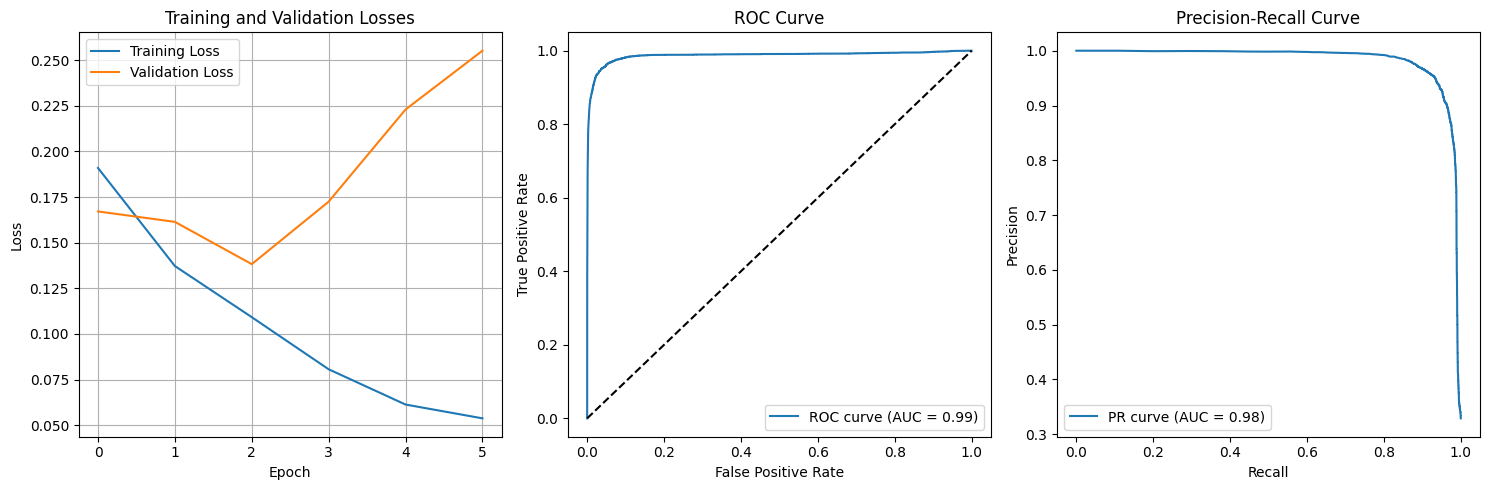

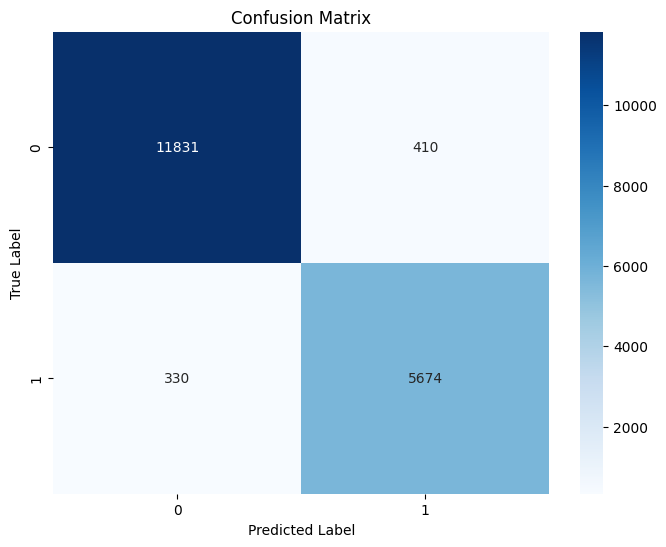

In [18]:
train_dataset, val_dataset, test_dataset = create_data_splits(
        texts=ds['train']['text'],
        labels=ds['train']['is_offensive'],
        tokenizer=tokenizer,
        test_size=0.20,
        val_size=0.25
    )

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16
)


# train model
train_losses, val_losses, val_recalls, _ = train_model(
     config, model, train_loader, val_loader, test_loader
  )

# Load best model and evaluate by loading model weights onto the correct device
state_dict = torch.load('best_model.pt', map_location=device, weights_only=True)

# Load  weights and other necessary state information into the model
model.load_state_dict(state_dict)

test_metrics = evaluate_model(model, test_loader, device)

In [29]:
flderpath = '/content/finetunedrbrta/'
mdlpath = flderpath+ 'pytorch_model.bin'
torch.save(model.state_dict(), mdlpath)
tokenizer.save_pretrained(flderpath)

('/content/finetunedrbrta/tokenizer_config.json',
 '/content/finetunedrbrta/special_tokens_map.json',
 '/content/finetunedrbrta/vocab.json',
 '/content/finetunedrbrta/merges.txt',
 '/content/finetunedrbrta/added_tokens.json',
 '/content/finetunedrbrta/tokenizer.json')

In [30]:
import warnings, os
warnings.filterwarnings("ignore")
def infer_robertasentencevalidator(contextstr, mdlpath='/content/finetunedrbrta'):
    try:
        ft_model = CustomRobertaPFClassifier()
        mdlpath = mdlpath+'/'
        binpath = mdlpath + 'pytorch_model.bin'
        if os.path.exists(binpath):
            ft_model.load_state_dict(torch.load(binpath))
            ft_model.eval()
            tokenizer = AutoTokenizer.from_pretrained(mdlpath)
            result = {}

            result['contextstr'] = contextstr
            with torch.no_grad():
                #Tokenize inputs
                inputs = tokenizer(contextstr, return_tensors="pt")
                output = ft_model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                # get the outputtensor
                evallabel = output[0].argmax().item()
                result['evallabel'] = evallabel
                if evallabel==1:
                  result['prediction'] = 'offensive'
                else:
                  result['prediction'] = 'non-offensive'
            return result

    except Exception as e:
        return (f"Encountered error while performing inference: {e}")

In [31]:
infer_robertasentencevalidator(contextstr="you worst fellow")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'contextstr': 'you worst fellow', 'evallabel': 1, 'prediction': 'offensive'}

In [32]:
testlist=["You worst idiot","You are asshole","You bloody nasty fellow",
          "You are pretty", "Its a bright morning", "its been a great pleasure talking to you",
          "You shut up and don't change my contributions!!!!", "shit-faced loser screw you",
          "I hate to talk to you", "you're blanking my comments you idiot you will pay for this",
          "He is a devil", "Exactly. Problem solved you moron", "You sounded like a fag the last three days",
          "Cursed how much everything happens on earth", "Few people do not have good hygiene",
          "You all should be locked or deserted alone"
          ]

In [ ]:
resultdict = {'contextstr': [], 'evallabel': [], 'predictionresult': []}

for s in testlist:
    t = infer_robertasentencevalidator(contextstr=s)
    resultdict['contextstr'].append(s)
    resultdict['evallabel'].append(t['evallabel'])
    resultdict['predictionresult'].append(t['prediction'])
resultdf = pd.DataFrame(resultdict)

In [35]:
resultdf

,contextstr,evallabel,predictionresult
0,You worst idiot,1,offensive
1,You are asshole,1,offensive
2,You bloody nasty fellow,1,offensive
3,You are pretty,0,non-offensive
4,Its a bright morning,0,non-offensive
5,its been a great pleasure talking to you,0,non-offensive
6,You shut up and don't change my contributions!!!!,1,offensive
7,shit-faced loser screw you,1,offensive
8,I hate to talk to you,1,offensive
9,you're blanking my comments you idiot you will...,1,offensive
